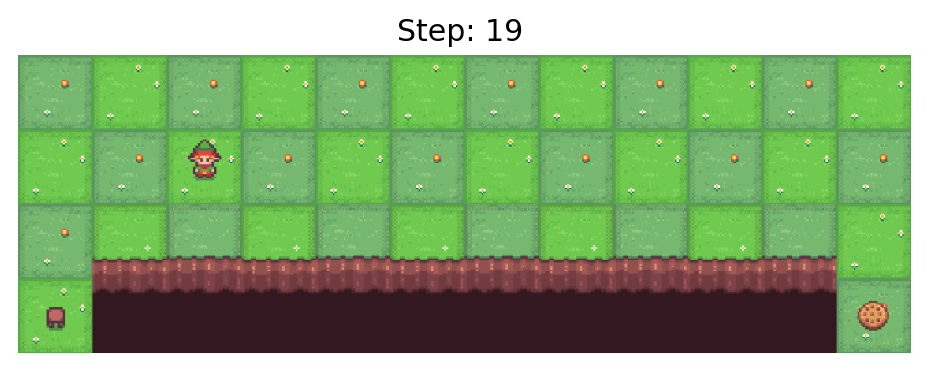

In [1]:
import gym
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

print("gym.__version__=",gym.__version__)


%matplotlib inline

#可视化函数：
def show_state(env, step, info=""):
    plt.figure(num=0,dpi=180)
    plt.clf()
    plt.imshow(env.render())
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    
env = gym.make("CliffWalking-v0",render_mode="rgb_array")  # 0 up, 1 right, 2 down, 3 left
env.reset()

for step in range(20):
    time.sleep(0.2)
    
    action = np.random.randint(0, 4)
    obs, reward, done,truncated, info = env.step(action)
    
    #env.render() 
    show_state(env,step=step)
    #print('step {}: action {}, obs {}, reward {}, done {}, truncated {}, info {}'.format(\
    #        step, action, obs, reward, done, truncated,info))
    
display.clear_output(wait=True)

In [2]:
import torch 
from torch import nn 

class QAgent(nn.Module):
    def __init__(self, obs_n, act_n, learning_rate=0.01, gamma=0.9, e_greed=0.1):
        super().__init__()
        self.act_n = act_n      # 动作维度，有几个动作可选
        self.lr = learning_rate # 学习率
        self.gamma = gamma      # reward的衰减率
        self.epsilon = e_greed  # 按一定概率随机选动作
        self.Q = nn.Parameter(torch.zeros((obs_n, act_n)),requires_grad=False)

    # 根据输入观察值，采样输出的动作值，带探索
    def sample(self, obs):
        if np.random.uniform(0, 1) < (1.0 - self.epsilon): #根据table的Q值选动作
            action = self.predict(obs)
        else:
            action = np.random.choice(self.act_n) #有一定概率随机探索选取一个动作
        return action
    
    # 根据输入观察值，预测输出的动作值
    def forward(self,obs):
        Q_list = self.Q[obs, :]
        maxQ = Q_list.max()
        action_list = torch.where(Q_list == maxQ)[0].tolist()  # maxQ可能对应多个action
        action = np.random.choice(action_list)
        return action

    
    @torch.no_grad()
    def predict(self,obs):
        self.eval()
        return self.forward(obs)
    

    # 学习方法，也就是更新Q-table的方法
    def learn(self, obs, action, reward, next_obs, done):
        """ on-policy
            obs: 交互前的obs, s_t
            action: 本次交互选择的action, a_t
            reward: 本次动作获得的奖励r
            next_obs: 本次交互后的obs, s_t+1
            next_action: 根据当前Q表格, 针对next_obs会选择的动作, a_t+1
            done: episode是否结束
        """
        predict_Q = self.Q[obs, action]
        if done:
            target_Q = reward # 没有下一个状态了
        else:
            target_Q = reward + self.gamma * self.Q[next_obs, :].max() # Q-learning
        self.Q[obs, action] += self.lr * (target_Q - predict_Q) # 修正q

In [3]:
# 使用gym创建悬崖环境
env = gym.make("CliffWalking-v0")  # 0 up, 1 right, 2 down, 3 left

# 创建一个agent实例，输入超参数
agent = QAgent(
        obs_n=env.observation_space.n,
        act_n=env.action_space.n,
        learning_rate=0.1,
        gamma=0.9,
        e_greed=0.1)

In [4]:
class DataLoader:
    def __init__(self,env,agent,stage='train'):
        self.env = env
        self.agent = agent 
        self.stage = stage
        
    def __iter__(self):

        obs,info = self.env.reset() # 重置环境, 重新开一局（即开始新的一个episode）
        action = self.agent.sample(obs) # 根据算法选择一个动作

        while True:
            next_obs, reward, done, _, _ = self.env.step(action) # 与环境进行一个交互
            if self.stage =='train':
                next_action = self.agent.sample(next_obs) # 训练阶段使用探索-利用策略
            else:
                next_action = self.agent.predict(next_obs) # 验证阶段使用模型预测结果

            yield obs, action, reward, next_obs, done
            action = next_action
            obs = next_obs   

            if done:
                break
    def __len__(self):
        return 1000

dl_train = DataLoader(env,agent,stage='train')
dl_train.size = 1000

dl_val = DataLoader(env,agent,stage='val')
dl_val.size = 200

In [5]:
import sys,datetime
from tqdm import tqdm
import numpy as np

from accelerate import Accelerator
from torchkeras import KerasModel
import pandas as pd 
from torchkeras.utils import is_jupyter,colorful

from copy import deepcopy

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator()
    
    def __call__(self, batch):
        
        obs, action, reward, next_obs, done = batch
        
        #backward()
        if self.stage=="train":
             self.net.learn(obs, action, reward, next_obs, done)
            
        #losses （or plain metric）
        step_losses = {self.stage+'_reward':reward, 
                       self.stage+'_done':1.0 if done else 0.0}
        
        #metrics (stateful metric)
        step_metrics = {}
        if self.stage=='train':
            step_metrics['lr'] = self.net.lr
        return step_losses,step_metrics
    

class EpochRunner:
    def __init__(self,steprunner,quiet=False):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        self.accelerator = steprunner.accelerator
        self.net = steprunner.net
        self.quiet = quiet
        
    def __call__(self,dataloader):
        dataloader.agent = self.net 
        n = dataloader.size  if hasattr(dataloader,'size') else len(dataloader)
        loop = tqdm(enumerate(dataloader,start=1), 
                    total=n,
                    file=sys.stdout,
                    disable=not self.accelerator.is_local_main_process or self.quiet,
                    ncols=100
                   )
        epoch_losses = {}
        for step, batch in loop: 
            step_losses,step_metrics = self.steprunner(batch)   
            step_log = dict(step_losses,**step_metrics)
            for k,v in step_losses.items():
                epoch_losses[k] = epoch_losses.get(k,0.0)+v

            if step_log[self.stage+'_done']<1 and step<n:
                loop.set_postfix(**step_log)



            elif step_log[self.stage+'_done']>0.5 or step==n:
                epoch_metrics = step_metrics
                epoch_metrics.update({self.stage+"_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in self.steprunner.metrics_dict.items()})
                epoch_losses = {k:v for k,v in epoch_losses.items()}
                epoch_log = dict(epoch_losses,**epoch_metrics)
                epoch_log[self.stage+'_step']=step
                loop.set_postfix(**epoch_log)



                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
                loop.close()
            else:
                break
        return epoch_log
    
KerasModel.StepRunner = StepRunner
KerasModel.EpochRunner = EpochRunner 

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


<<<<<< 🐌 cpu is used >>>>>>


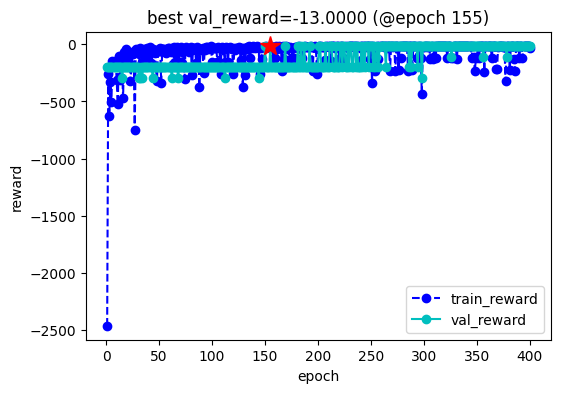

/cloud/ql/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [6]:
keras_model = KerasModel(net= agent,loss_fn=None)
dfhistory = keras_model.fit(train_data = dl_train,
    val_data=dl_val,
    epochs=400,
    ckpt_path='checkpoint.pt',
    patience=300,
    monitor='val_reward',
    mode='max',
    callbacks=None,
    quiet=True, 
    plot=True,
    cpu=True)

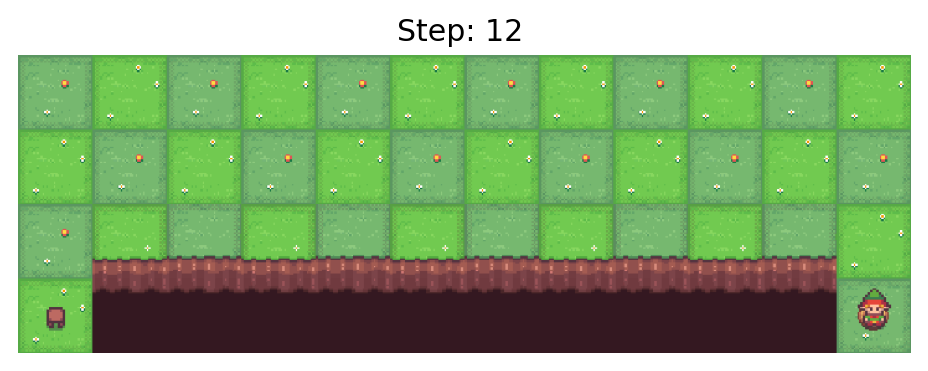

test reward = -13.0


In [8]:
keras_model.load_ckpt('checkpoint.pt')
agent = keras_model.net 
def test_agent(env, agent):
    total_reward = 0
    obs,info = env.reset()
    step=0
    while True:
        action = agent.predict(obs) # greedy
        next_obs, reward, done, _ ,_ = env.step(action)
        total_reward += reward
        obs = next_obs
        time.sleep(0.5)
        show_state(env,step)
        step+=1
        if done:
            break
    plt.close()
    return total_reward

# 全部训练结束，查看算法效果
env = gym.make("CliffWalking-v0",render_mode="rgb_array")  # 0 up, 1 right, 2 down, 3 left
test_reward = test_agent(env, agent)
print('test reward = %.1f' % (test_reward))

In [ ]:
torch.save(keras_model.net.state_dict(),'best_ckpt.pt') 
